In [1]:
import torch

# Check if CUDA is available
print("CUDA is available:" if torch.cuda.is_available() else "CUDA is NOT available.")
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0))

CUDA is available:
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
!nvidia-smi

Mon Feb  3 19:58:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P3             13W /   70W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Download and load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [03:21<00:00, 847kB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


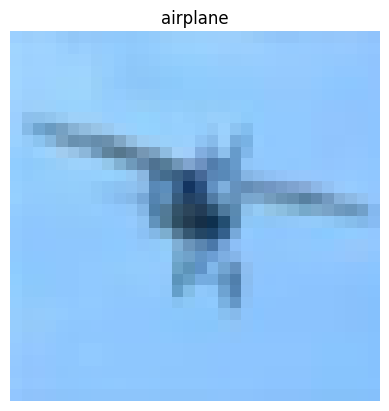

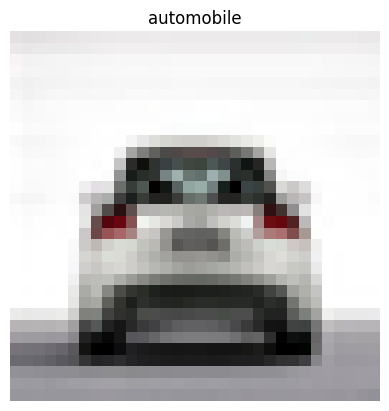

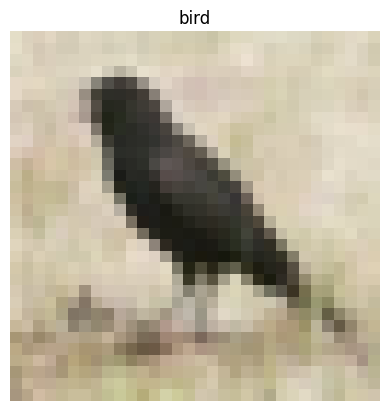

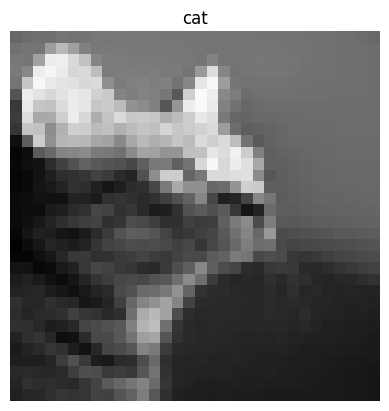

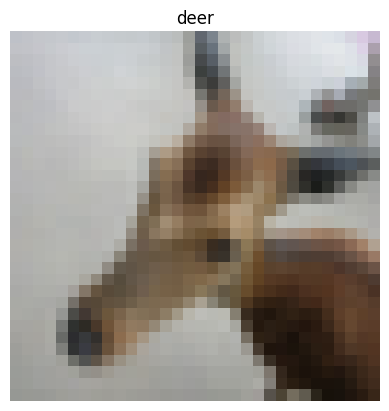

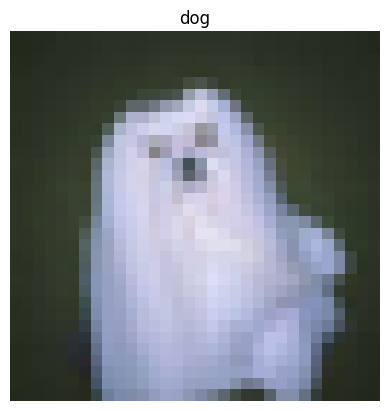

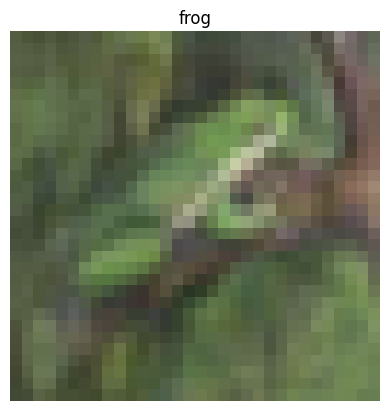

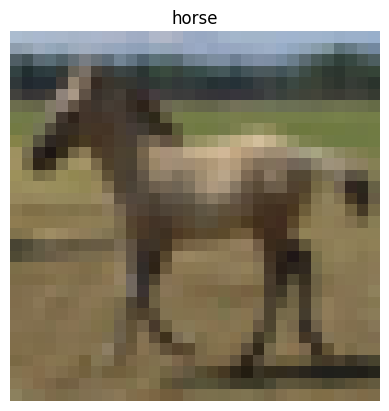

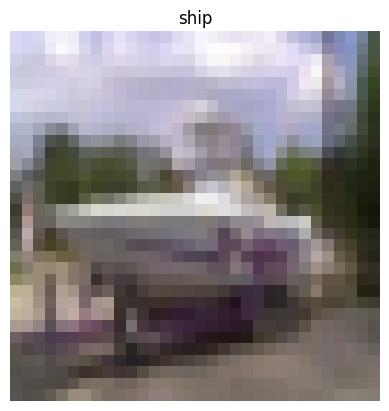

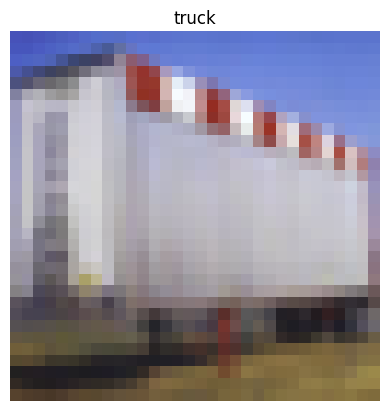

In [7]:
# Function to display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one image per class
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
selected_images = []
selected_labels = []

# Iterate through the dataset to find one image per class
for class_idx in range(10):  # There are 10 classes in CIFAR-10
    for images, labels in train_loader:
        for image, label in zip(images, labels):
            if label == class_idx:
                selected_images.append(image)
                selected_labels.append(label)
                break
        if len(selected_images) > class_idx:
            break

# Display one image per class
for i in range(10):
    imshow(selected_images[i], title=class_names[selected_labels[i]])

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [9]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [10]:
# Hyperparameters
latent_dim = 100
img_shape = (3, 32, 32)  # CIFAR-10 images are 32x32 with 3 color channels

# Initialize generator and discriminator
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Check if CUDA is available and move models to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Create a directory to save generated images
os.makedirs("generated_images", exist_ok=True)

# Training parameters
epochs = 100
latent_dim = 100
n_classes = 10  # CIFAR-10 has 10 classes
img_shape = (3, 32, 32)  # CIFAR-10 image shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize generator and discriminator
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Lists to store losses
G_losses = []
D_losses = []

# Fixed noise for generating images for each class
fixed_noise = torch.randn(n_classes, latent_dim, device=device)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Move images to the appropriate device
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        # Backpropagate and optimize
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagate and optimize
        d_loss.backward()
        optimizer_D.step()

        # Store losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Print progress
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] "
                f"[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
            )

    # Generate and save images for each class at the end of each epoch
    with torch.no_grad():
        # Generate images from fixed noise
        gen_imgs = generator(fixed_noise).cpu()

        # Save the generated images as a grid
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title(f"Generated Images at Epoch {epoch}")
        plt.imshow(np.transpose(vutils.make_grid(gen_imgs, nrow=5, padding=2, normalize=True), (1, 2, 0)))
        plt.savefig(f"generated_images/epoch_{epoch}.png")
        plt.close()



[Epoch 0/100] [Batch 0/391] [D loss: 0.6896794438362122] [G loss: 0.6861297488212585]
[Epoch 0/100] [Batch 100/391] [D loss: 0.31201863288879395] [G loss: 1.1782885789871216]
[Epoch 0/100] [Batch 200/391] [D loss: 0.522976279258728] [G loss: 1.3295857906341553]
[Epoch 0/100] [Batch 300/391] [D loss: 0.24795809388160706] [G loss: 1.5718365907669067]
[Epoch 1/100] [Batch 0/391] [D loss: 0.491321325302124] [G loss: 1.31777024269104]
[Epoch 1/100] [Batch 100/391] [D loss: 0.6300530433654785] [G loss: 1.8525865077972412]
[Epoch 1/100] [Batch 200/391] [D loss: 0.437480092048645] [G loss: 1.1625747680664062]
[Epoch 1/100] [Batch 300/391] [D loss: 0.3053589463233948] [G loss: 1.4948036670684814]
[Epoch 2/100] [Batch 0/391] [D loss: 0.41535475850105286] [G loss: 1.6933839321136475]
[Epoch 2/100] [Batch 100/391] [D loss: 1.7383912801742554] [G loss: 3.8615260124206543]
[Epoch 2/100] [Batch 200/391] [D loss: 0.5197737812995911] [G loss: 1.2744776010513306]
[Epoch 2/100] [Batch 300/391] [D loss: 0

In [12]:
# Save the final models
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")


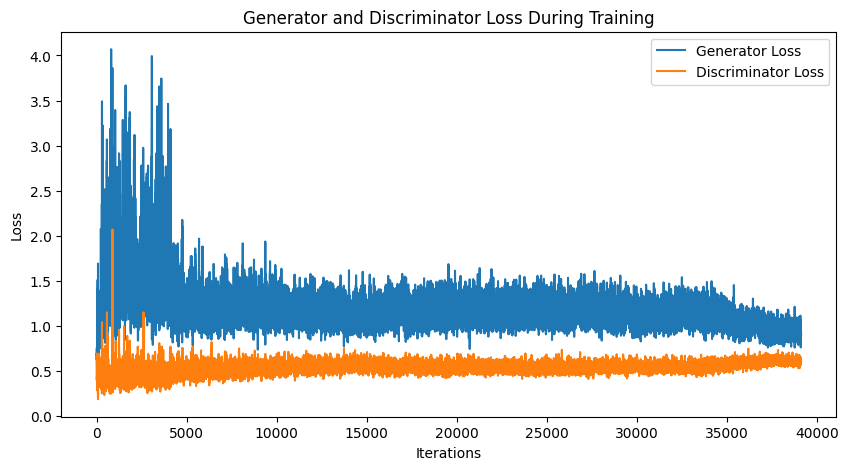

In [13]:

# Plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

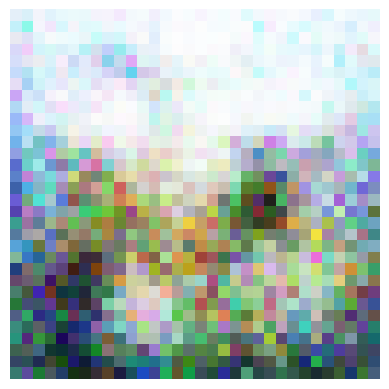

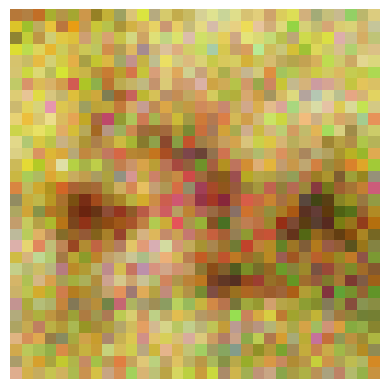

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the Generator class (EXACT architecture from training)
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, eps=0.8, momentum=0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# 2. Define the image generation function
def generate_image(generator, latent_dim, device, save_path=None):
    # Generate random noise
    z = torch.randn(1, latent_dim).to(device)
    
    # Generate image
    with torch.no_grad():
        gen_img = generator(z).cpu()
    
    # Rescale image from [-1, 1] to [0, 1]
    gen_img = gen_img / 2 + 0.5
    gen_img = gen_img.numpy().transpose(0, 2, 3, 1)  # Convert to HWC format
    
    # Plot or save the image
    plt.imshow(gen_img[0])
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# 3. Load the model and generate images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=100, img_shape=(3, 32, 32)).to(device)

# Load weights (add weights_only=True if you trust the file)
generator.load_state_dict(
    torch.load("generator_final.pth", 
               map_location=device, 
               weights_only=True)  # Change to False if you get errors
)
generator.eval()

# Generate and display an image
generate_image(generator, latent_dim=100, device=device, save_path="generated_image.png")
# 2. Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=100, img_shape=(3, 32, 32)).to(device)
generator.load_state_dict(torch.load("generator_final.pth", map_location=device, weights_only=True))
generator.eval()

# 3. Generate images (use your existing function)
generate_image(generator, latent_dim=100, device=device, save_path="generated_image.png")

In [ ]:
#another GAN with CNN

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=False),  # (N, latent_dim, 1, 1) -> (N, 128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # (N, 128, 4, 4) -> (N, 64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),  # (N, 64, 8, 8) -> (N, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),  # (N, 32, 16, 16) -> (N, 3, 32, 32)
            nn.Tanh()  # Output layer
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape to (N, latent_dim, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (N, 3, 32, 32) -> (N, 32, 16, 16)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1),  # (N, 32, 16, 16) -> (N, 64, 8, 8)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # (N, 64, 8, 8) -> (N, 128, 4, 4)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),  # (N, 128, 4, 4) -> (N, 256, 2, 2)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 1),  # Flatten to (N, 256*2*2)
            nn.Sigmoid(),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity




In [31]:
# Hyperparameters
latent_dim = 100
img_shape = (3, 32, 32)  # CIFAR-10 images are 32x32 with 3 color channels
# Training parameters
epochs = 100
n_classes = 10  # CIFAR-10 has 10 classes


# Initialize generator and discriminator
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Check if CUDA is available and move models to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:

# Create a directory to save generated images
os.makedirs("generated_images_CNN", exist_ok=True)



# Initialize generator and discriminator
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)


In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Lists to store losses
G_losses = []
D_losses = []

# Fixed noise for generating images for each class
fixed_noise = torch.randn(n_classes, latent_dim, device=device)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Move images to the appropriate device
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        # Backpropagate and optimize
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagate and optimize
        d_loss.backward()
        optimizer_D.step()

        # Store losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Print progress
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] "
                f"[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
            )

    # Generate and save images for each class at the end of each epoch
    with torch.no_grad():
        # Generate images from fixed noise
        gen_imgs = generator(fixed_noise).cpu()

        # Save the generated images as a grid
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title(f"Generated Images at Epoch {epoch}")
        plt.imshow(np.transpose(vutils.make_grid(gen_imgs, nrow=5, padding=2, normalize=True), (1, 2, 0)))
        plt.savefig(f"generated_images/epoch_{epoch}.png")
        plt.close()



[Epoch 0/100] [Batch 0/391] [D loss: 0.6861141920089722] [G loss: 0.9022530913352966]
[Epoch 0/100] [Batch 100/391] [D loss: 0.013476050458848476] [G loss: 4.954736709594727]
[Epoch 0/100] [Batch 200/391] [D loss: 0.09136982262134552] [G loss: 3.8613762855529785]
[Epoch 0/100] [Batch 300/391] [D loss: 0.07387186586856842] [G loss: 3.297360420227051]
[Epoch 1/100] [Batch 0/391] [D loss: 0.11708231270313263] [G loss: 3.5744919776916504]
[Epoch 1/100] [Batch 100/391] [D loss: 0.06990235298871994] [G loss: 3.3752920627593994]
[Epoch 1/100] [Batch 200/391] [D loss: 0.07678866386413574] [G loss: 3.566063642501831]
[Epoch 1/100] [Batch 300/391] [D loss: 0.08454960584640503] [G loss: 2.9855599403381348]
[Epoch 2/100] [Batch 0/391] [D loss: 0.13110505044460297] [G loss: 1.966489315032959]
[Epoch 2/100] [Batch 100/391] [D loss: 0.5809553265571594] [G loss: 0.6349714994430542]
[Epoch 2/100] [Batch 200/391] [D loss: 0.10144152492284775] [G loss: 2.768571138381958]
[Epoch 2/100] [Batch 300/391] [D 

In [34]:
# Save the final models
torch.save(generator.state_dict(), "generator_final_cnn.pth")
torch.save(discriminator.state_dict(), "discriminator_final_cnn.pth")


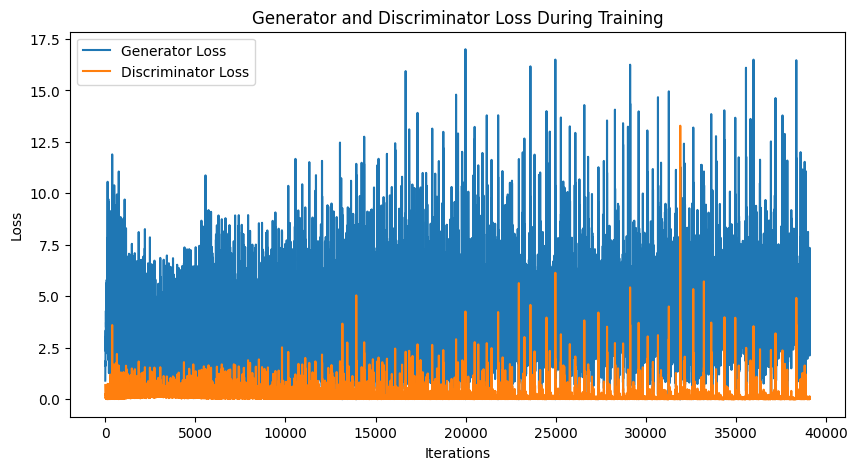

In [35]:

# Plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_plot_cnn.png")
plt.show()

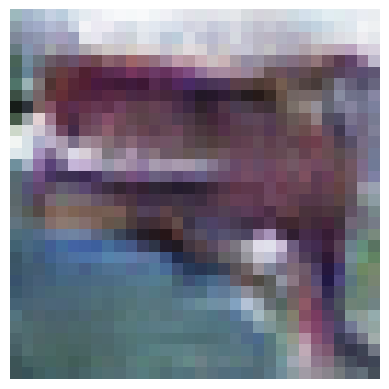

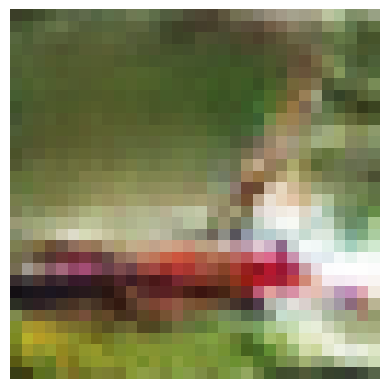

In [37]:
#load model and generate image 
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=False),  # (N, latent_dim, 1, 1) -> (N, 128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # (N, 128, 4, 4) -> (N, 64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),  # (N, 64, 8, 8) -> (N, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),  # (N, 32, 16, 16) -> (N, 3, 32, 32)
            nn.Tanh()  # Output layer
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape to (N, latent_dim, 1, 1)
        img = self.model(z)
        return img


# 3. Load the model and generate images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=100, img_shape=(3, 32, 32)).to(device)

# Load weights (add weights_only=True if you trust the file)
generator.load_state_dict(
    torch.load("generator_final_cnn.pth", 
               map_location=device, 
               weights_only=True)  # Change to False if you get errors
)
generator.eval()

# Generate and display an image
generate_image(generator, latent_dim=100, device=device, save_path="generated_image_cnn.png")
# 2. Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=100, img_shape=(3, 32, 32)).to(device)
generator.load_state_dict(torch.load("generator_final_cnn.pth", map_location=device, weights_only=True))
generator.eval()

# 3. Generate images (use your existing function)
generate_image(generator, latent_dim=100, device=device, save_path="generated_image_cnn.png")